In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch.utils.data import random_split
from matplotlib import pyplot as plt
import shap
from sklearn.model_selection import train_test_split

In [24]:
train_series = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')

In [104]:
def prep_nosubject(df):
    scs = {}
    for col in df.columns[3:]:
        sc = StandardScaler()
        train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
        scs[col] = sc
    
    for sensor in df.columns[3:]:
        df[sensor+'_square'] = np.square(df[sensor])
        df[sensor+'_diff'] = df[sensor].diff()
        df.loc[df['step']==0, sensor+'_diff'] = 0.0
        df[sensor+'_mean5'] = df[sensor].rolling(5).mean().fillna(0)
        df[sensor+'_mean10'] = df[sensor].rolling(10).mean().fillna(0)
        df[sensor+'_mean20'] = df[sensor].rolling(20).mean().fillna(0)
    
    for col in df.columns[16:]:
        sc = StandardScaler()
        train_series[col] = sc.fit_transform(train_series[col].values.reshape(-1,1))
        scs[col] = sc
    
    return scs

In [26]:
scs = prep_nosubject(train_series)

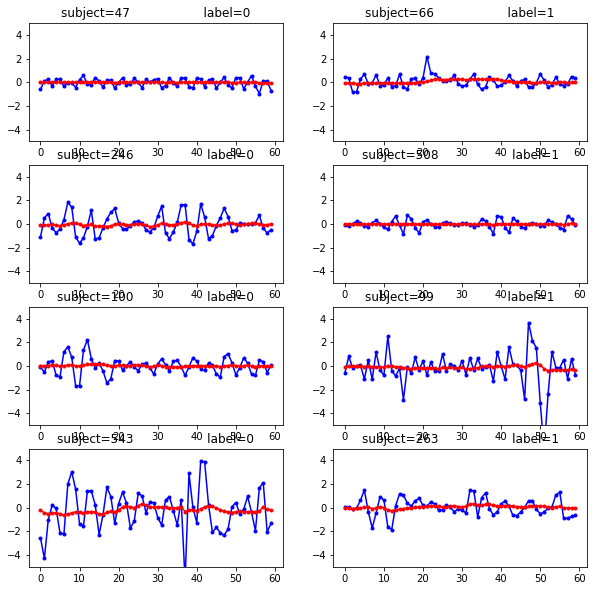

In [28]:
seqs = [0,1,6,11,14,15,19,18]
fig, axs = plt.subplots(4,2,figsize=(10,10))
axs = axs.flatten()
for idx, seq in enumerate(seqs):
    irow = (train_series['sequence']==seq)
    subject = train_series.loc[irow,'subject'].iloc[0]
    tmp1 = train_series.loc[irow,'sensor_04'].values
    tmp2 = train_series.loc[irow,'sensor_04_mean20'].values
    ax = axs[idx]
    ax.set_title(f"subject={subject} \
                  label={train_labels.loc[seq].values[0]}")
    ax.set_ylim([-5,5])
    ax.plot(tmp1,'b.-')
    ax.plot(tmp2,'r.-')

In [79]:
class MyModel(nn.Module):
    def __init__(self, input_feature, hidden_size, num_layers=1):
        super(MyModel, self).__init__()
        self.gru = nn.GRU(input_feature, hidden_size, batch_first=True, num_layers=num_layers, dropout=0.2)
        ''' gru input is (N,L,H_in=H_hidden), output is (N,L,H_hidden), hidden is (num_layers, h_hidden)'''
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input, hidden):
        ''' X is in the shape of (N,L,input_feature) '''
        output, hidden = self.gru(input, hidden)
        output = output[:,-1,:]
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.sigmoid(self.fc3(output)).squeeze(dim=1)
        return output
    
    def initHidden(self, batch_size):
        return torch.zeros((self.num_layers, batch_size, self.hidden_size))

In [77]:
class MyDataset(Dataset):
    def __init__(self, series, labels=None):
        self.X = series.drop(columns=['sequence','subject','step']).values
        self.X = self.X.reshape(-1,60,series.shape[1]-3).copy()
        if labels is None:
            self.y = None
        else:
            self.y = labels['state'].values
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        ''' input tensor shape is N*C*L '''
        X = self.X[idx]
        if self.y is None:
            y = -1
        else:
            y = self.y[idx]
        return (torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))

In [33]:
mydataset = MyDataset(train_series, train_labels)

In [35]:
train_series

sequence  subject  step  sensor_00  sensor_01  sensor_02  sensor_03  \
0               0       47     0  -0.073994   0.025755   0.529941   0.084226   
1               0       47     1  -0.168462   0.030764   0.529941  -0.166807   
2               0       47     2   0.122789  -0.157416   0.529941   0.084451   
3               0       47     3   0.196619   0.170766   0.529941   0.248882   
4               0       47     4   0.102151   0.244225   0.529941  -0.034093   
...           ...      ...   ...        ...        ...        ...        ...   
1558075     25967      327    55  -0.106549  -0.276191  -0.630265   0.149683   
1558076     25967      327    56   0.048959   0.079657  -0.630265  -0.082005   
1558077     25967      327    57  -0.218166   0.097783  -0.630265   0.081752   
1558078     25967      327    58   0.480893   0.388758  -0.567891   0.204569   
1558079     25967      327    59  -0.427448  -0.840493  -0.485211  -0.194250   

         sensor_04  sensor_05  sensor_06  ...  sensor_11_square  \
0        -0.595617  -0.081710  -0.037993  ...          0.013965   
1         0.097598   0.214962  -0.062496  ...          0.002525   
2         0.282421   0.805957  -0.028192  ...          0.016527   
3        -0.333470  -0.451728   0.237261  ...          0.088499   
4         0.237816   0.029248   0.167563  ...          0.000787   
...            ...        ...        ...  ...               ...   
1558075  -0.551688  -0.282470  -0.194542  ...          0.005969   
1558076   0.461579  -0.208184   0.029800  ...          0.018079   
1558077   0.184530   0.178760  -0.153159  ...          0.129697   
1558078  -0.272446  -0.033754   0.719161  ...          0.006589   
1558079  -0.254322  -0.056792  -0.751041  ...          0.102336   

         sensor_11_diff  sensor_11_mean5  sensor_11_mean10  sensor_11_mean20  \
0              0.000000         0.000000          0.000000          0.000000   
1             -0.168420         0.000000          0.000000          0.000000   
2             -0.078308         0.000000          0.000000          0.000000   
3              0.426043         0.000000          0.000000          0.000000   
4             -0.269426         0.052984          0.000000          0.000000   
...                 ...              ...               ...               ...   
1558075        0.082621        -0.009390          0.017348         -0.003375   
1558076       -0.057199        -0.036764         -0.039488         -0.024905   
1558077        0.494592         0.007996         -0.006167          0.026518   
1558078       -0.278960         0.013943          0.041272          0.018097   
1558079       -0.401075        -0.018061          0.010380         -0.010355   

         sensor_12_square  sensor_12_diff  sensor_12_mean5  sensor_12_mean10  \
0                0.014827        0.000000         0.000000          0.000000   
1                0.000142       -0.109851         0.000000          0.000000   
2                0.014587       -0.132690         0.000000          0.000000   
3                0.000127        0.132047         0.000000          0.000000   
4                0.000029       -0.016683         0.003754          0.000000   
...                   ...             ...              ...               ...   
1558075          0.000533       -0.039741        -0.005061          0.002991   
1558076          0.000166        0.010199        -0.003451         -0.002988   
1558077          0.000578        0.036918         0.006446         -0.000534   
1558078          0.000033       -0.018328         0.002085          0.004296   
1558079          0.001569       -0.045320        -0.009170         -0.002453   

         sensor_12_mean20  
0                0.000000  
1                0.000000  
2                0.000000  
3                0.000000  
4                0.000000  
...                   ...  
1558075         -0.000326  
1558076         -0.000828  
1558077          0.002876  
1558078          0.000639  
1558079      

In [34]:
mydataset[0]

(tensor([[-0.0740,  0.0258,  0.5299,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1685,  0.0308,  0.5299,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.1228, -0.1574,  0.5299,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.3664, -0.5877,  0.3849,  ...,  0.0045,  0.0042,  0.0035],
         [-2.1194,  0.8231,  0.3849,  ..., -0.1576, -0.0599, -0.0324],
         [ 2.8336, -0.4069,  0.3849,  ..., -0.3981, -0.2040, -0.1057]]),
 tensor(0))

In [40]:
dataloader = DataLoader(mydataset, batch_size=4)
X, y = next(iter(dataloader))

In [54]:
model = MyModel(78,128)

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1


In [55]:
hidden = model.initHidden(4)

In [56]:
model(X, hidden)

torch.Size([4, 128])


tensor([[0.4989],
        [0.4899],
        [0.4864],
        [0.4884]], grad_fn=<SigmoidBackward0>)

In [85]:
lo98

In [88]:
def train(series, labels, weight_decay, epoches, seed, batch_size=512):
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_subjects, test_subjects = train_test_split(subjects, test_size=0.1)
    train_series = series.loc[series['subject'].isin(train_subjects)]
    test_series = series.loc[series['subject'].isin(test_subjects)]

    train_seqs = train_series['sequence'].unique()
    test_seqs = test_series['sequence'].unique()

    train_labels = labels.loc[labels['sequence'].isin(train_seqs)]
    test_labels = labels.loc[labels['sequence'].isin(test_seqs)]
    train_dataset = MyDataset(train_series, train_labels)
    test_dataset = MyDataset(test_series, test_labels)

    train_loader = DataLoader(train_dataset, shuffle=True, drop_last=False, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, drop_last=False,
                             batch_size=len(test_dataset))

    criteria = nn.BCELoss()
    print(weight_decay)
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

    best_score = 0.0
    model_name = 'gru_model_'+str(weight_decay)+'_seed_'+str(seed)+'.pickle'
    for epoch in range(epoches):

        curr_loss = 0.0
        model.train()

        for batch, (X, y) in enumerate(train_loader):
            hidden = model.initHidden(len(X))
            output = model(X, hidden)
            loss = criteria(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item() * len(y)

        curr_loss /= len(train_loader.dataset)
        score, test_loss = evaluate(test_loader)
        print(f"{weight_decay} {seed} - {epoch}: {curr_loss}; test roc={score} test loss={test_loss}")

        if (score > best_score):
            torch.save({'epoch':epoch,'train_loss':curr_loss, 'test_loss':test_loss, 'score':score,
                        'model':model.state_dict()}, model_name)
            best_score = score
            print(f'saving model: {best_score}, {model_name}')

In [61]:
subjects = train_series['subject'].unique()

In [63]:
train_labels

state
sequence       
0             0
1             1
2             1
3             1
4             1
...         ...
25963         1
25964         0
25965         1
25966         1
25967         0

[25968 rows x 1 columns]

In [64]:
train_labels = pd.read_csv('train_labels.csv')

In [102]:
class MyModel(nn.Module):
    def __init__(self, input_feature, hidden_size, num_layers=1):
        super(MyModel, self).__init__()
        self.gru = nn.GRU(input_feature, hidden_size, batch_first=True, num_layers=num_layers, dropout=0.5)
        ''' gru input is (N,L,H_in=H_hidden), output is (N,L,H_hidden), hidden is (num_layers, h_hidden)'''
        
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, input, hidden):
        ''' X is in the shape of (N,L,input_feature) '''
        output, hidden = self.gru(input, hidden)
        output = self.dropout(F.relu(self.bn(output[:,-1,:])))
        output = self.sigmoid(self.fc(output).squeeze(dim=1))
        return output
    
    def initHidden(self, batch_size):
        return torch.zeros((self.num_layers, batch_size, self.hidden_size))

In [99]:
sum_size = 0
for para in model.named_parameters():
    sum_size += np.prod(para[1].shape)
    print(f"{para[0]} || {np.prod(para[1].shape)}")
print(f"total = {sum_size}")

gru.weight_ih_l0 || 7488
gru.weight_hh_l0 || 3072
gru.bias_ih_l0 || 96
gru.bias_hh_l0 || 96
gru.weight_ih_l1 || 3072
gru.weight_hh_l1 || 3072
gru.bias_ih_l1 || 96
gru.bias_hh_l1 || 96
gru.weight_ih_l2 || 3072
gru.weight_hh_l2 || 3072
gru.bias_ih_l2 || 96
gru.bias_hh_l2 || 96
gru.weight_ih_l3 || 3072
gru.weight_hh_l3 || 3072
gru.bias_ih_l3 || 96
gru.bias_hh_l3 || 96
gru.weight_ih_l4 || 3072
gru.weight_hh_l4 || 3072
gru.bias_ih_l4 || 96
gru.bias_hh_l4 || 96
bn.weight || 32
bn.bias || 32
fc.weight || 32
fc.bias || 1
total = 36193


In [103]:
model = MyModel(78, 16, num_layers=5)
train(train_series, train_labels, 0.0, 200, 1)

0.0
0.0 1 - 0: 0.7083512398077388; test roc=0.5456895747311452 test loss=0.6891505122184753
saving model: 0.5456895747311452, gru_model_0.0_seed_1.pickle
0.0 1 - 1: 0.6965446771454814; test roc=0.5670404973522757 test loss=0.6852579712867737
saving model: 0.5670404973522757, gru_model_0.0_seed_1.pickle
0.0 1 - 2: 0.6882088212820083; test roc=0.587735904075396 test loss=0.6800644993782043
saving model: 0.587735904075396, gru_model_0.0_seed_1.pickle
0.0 1 - 3: 0.6799844273244897; test roc=0.6073649310658549 test loss=0.673805832862854
saving model: 0.6073649310658549, gru_model_0.0_seed_1.pickle
0.0 1 - 4: 0.667563486984544; test roc=0.6500314927566659 test loss=0.6546267867088318
saving model: 0.6500314927566659, gru_model_0.0_seed_1.pickle


KeyboardInterrupt: 

In [105]:
train_series = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')

In [106]:
scs = prep_nosubject(train_series)

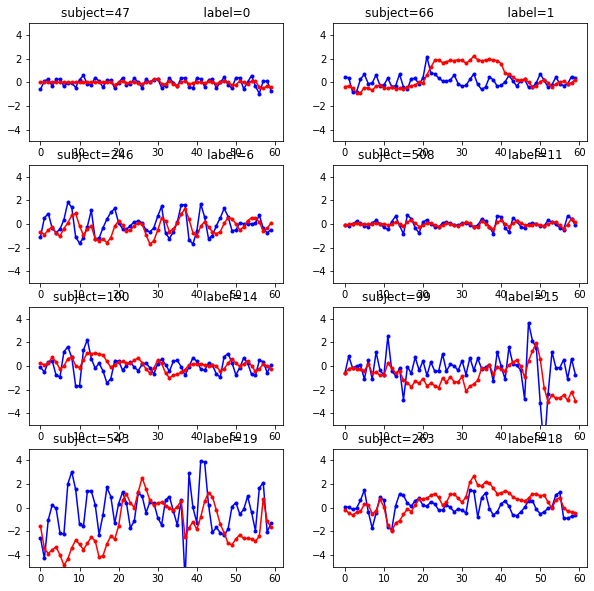

In [107]:
seqs = [0,1,6,11,14,15,19,18]
fig, axs = plt.subplots(4,2,figsize=(10,10))
axs = axs.flatten()
for idx, seq in enumerate(seqs):
    irow = (train_series['sequence']==seq)
    subject = train_series.loc[irow,'subject'].iloc[0]
    tmp1 = train_series.loc[irow,'sensor_04'].values
    tmp2 = train_series.loc[irow,'sensor_04_mean20'].values
    ax = axs[idx]
    ax.set_title(f"subject={subject} \
                  label={train_labels.loc[seq].values[0]}")
    ax.set_ylim([-5,5])
    ax.plot(tmp1,'b.-')
    ax.plot(tmp2,'r.-')

In [108]:
model = MyModel(78, 16, num_layers=5)
train(train_series, train_labels, 0.0, 200, 1)

0.0
0.0 1 - 0: 0.7096769743606137; test roc=0.5705583549117036 test loss=0.691998302936554
saving model: 0.5705583549117036, gru_model_0.0_seed_1.pickle
0.0 1 - 1: 0.691710526103141; test roc=0.6083140877598152 test loss=0.6819647550582886
saving model: 0.6083140877598152, gru_model_0.0_seed_1.pickle
0.0 1 - 2: 0.6737335240760755; test roc=0.6749405136818533 test loss=0.6696555018424988
saving model: 0.6749405136818533, gru_model_0.0_seed_1.pickle
0.0 1 - 3: 0.631864411199653; test roc=0.76880875731915 test loss=0.5780047178268433
saving model: 0.76880875731915, gru_model_0.0_seed_1.pickle
0.0 1 - 4: 0.5707721765702315; test roc=0.8584773835351203 test loss=0.5062389969825745
saving model: 0.8584773835351203, gru_model_0.0_seed_1.pickle
0.0 1 - 5: 0.4871733412609258; test roc=0.885553572678284 test loss=0.42451411485671997
saving model: 0.885553572678284, gru_model_0.0_seed_1.pickle
0.0 1 - 6: 0.44784745076207194; test roc=0.8940822777427857 test loss=0.4187752902507782
saving model: 0

0.0 1 - 74: 0.2704058035271924; test roc=0.9235245060302799 test loss=0.40501466393470764
0.0 1 - 75: 0.2705975966888238; test roc=0.9257359973872676 test loss=0.4116901159286499
0.0 1 - 76: 0.2721426543129951; test roc=0.9252985979891292 test loss=0.3983365297317505
0.0 1 - 77: 0.2674344390524782; test roc=0.9223333216693494 test loss=0.41173669695854187
0.0 1 - 78: 0.2697661998039742; test roc=0.9248716961765461 test loss=0.4012509882450104
0.0 1 - 79: 0.26930230103002034; test roc=0.9217900716168613 test loss=0.3935225307941437
0.0 1 - 80: 0.26440224755529707; test roc=0.9181520750227449 test loss=0.38859081268310547
0.0 1 - 81: 0.26370961365186557; test roc=0.9226511652319965 test loss=0.3912169337272644
0.0 1 - 82: 0.2685371615358622; test roc=0.9221271607530268 test loss=0.3812771737575531
0.0 1 - 83: 0.264722257722363; test roc=0.9250752326964798 test loss=0.40191763639450073
0.0 1 - 84: 0.2643986096897392; test roc=0.9219122518487415 test loss=0.4054577648639679
0.0 1 - 85: 0.2

KeyboardInterrupt: 

In [121]:
class MyDataset(Dataset):
    def __init__(self, series, labels=None, roll=False):
        self.X = series.drop(columns=['sequence','subject','step']).values
        self.X = self.X.reshape(-1,60,series.shape[1]-3).copy()
        if labels is None:
            self.y = None
        else:
            self.y = labels['state'].values
        self.roll = roll
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        ''' input tensor shape is N*L*C '''
        X = self.X[idx]
        toroll = np.random.choice(np.arange(-60,60))
        X = np.roll(X, toroll, axis=0)
        if self.y is None:
            y = -1
        else:
            y = self.y[idx]
        return (torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))

In [123]:
mydataset = MyDataset(train_series, train_labels, roll=True)

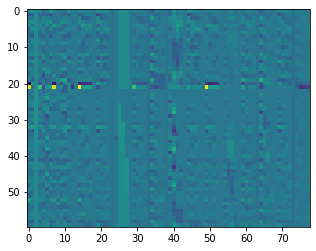

In [143]:
X, y = mydataset[0]
plt.imshow(X)

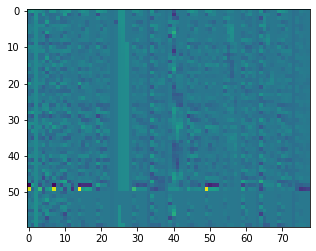

In [120]:
plt.imshow(np.roll(X.numpy(), -10, axis=0))

In [145]:
def train(series, labels, weight_decay, epoches, seed, batch_size=512):
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_subjects, test_subjects = train_test_split(subjects, test_size=0.1)
    train_series = series.loc[series['subject'].isin(train_subjects)]
    test_series = series.loc[series['subject'].isin(test_subjects)]

    train_seqs = train_series['sequence'].unique()
    test_seqs = test_series['sequence'].unique()

    train_labels = labels.loc[labels['sequence'].isin(train_seqs)]
    test_labels = labels.loc[labels['sequence'].isin(test_seqs)]
    train_dataset = MyDataset(train_series, train_labels, roll=True)
    test_dataset = MyDataset(test_series, test_labels)

    train_loader = DataLoader(train_dataset, shuffle=True, drop_last=False, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, drop_last=False,
                             batch_size=len(test_dataset))

    criteria = nn.BCELoss()
    print(weight_decay)
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

    best_score = 0.0
    model_name = 'gru_model_'+str(weight_decay)+'_seed_'+str(seed)+'.pickle'
    for epoch in range(epoches):

        curr_loss = 0.0
        model.train()

        for batch, (X, y) in enumerate(train_loader):
            hidden = model.initHidden(len(X))
            output = model(X, hidden)
            loss = criteria(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item() * len(y)

        curr_loss /= len(train_loader.dataset)
        score, test_loss = evaluate(test_loader)
        print(f"{weight_decay} {seed} - {epoch}: {curr_loss}; test roc={score} test loss={test_loss}")

        if (score > best_score):
            torch.save({'epoch':epoch,'train_loss':curr_loss, 'test_loss':test_loss, 'score':score,
                        'model':model.state_dict()}, model_name)
            best_score = score
            print(f'saving model: {best_score}, {model_name}')

## model = MyModel(78, 16, num_layers=5)
train(train_series, train_labels, 0.0, 200, 1)

In [149]:
model = MyModel(78, 16, num_layers=5)
train(train_series, train_labels, 1e-3, 200, 1)

0.001
0.001 1 - 0: 0.715631705470716; test roc=0.5469134182471366 test loss=0.691089928150177
saving model: 0.5469134182471366, gru_model_0.001_seed_1.pickle
0.001 1 - 1: 0.6964272290507784; test roc=0.5665339888492313 test loss=0.6859582662582397
saving model: 0.5665339888492313, gru_model_0.001_seed_1.pickle
0.001 1 - 2: 0.6903561222930553; test roc=0.5764836587584856 test loss=0.6835846900939941
saving model: 0.5764836587584856, gru_model_0.001_seed_1.pickle
0.001 1 - 3: 0.6853162939607002; test roc=0.613925047239135 test loss=0.6752579808235168
saving model: 0.613925047239135, gru_model_0.001_seed_1.pickle
0.001 1 - 4: 0.6721950963460545; test roc=0.6571453565679892 test loss=0.6560012102127075
saving model: 0.6571453565679892, gru_model_0.001_seed_1.pickle
0.001 1 - 5: 0.6484342487145606; test roc=0.7316228100870132 test loss=0.6288434863090515
saving model: 0.7316228100870132, gru_model_0.001_seed_1.pickle
0.001 1 - 6: 0.6070524746945156; test roc=0.7722204726246297 test loss=0.5

0.001 1 - 70: 0.32111806347005717; test roc=0.9197010520913523 test loss=0.36389604210853577
0.001 1 - 71: 0.3167529532720897; test roc=0.9208149625586115 test loss=0.36470288038253784
0.001 1 - 72: 0.3199455272506057; test roc=0.9204743742272612 test loss=0.37121352553367615
0.001 1 - 73: 0.31968319729526395; test roc=0.9209138148225908 test loss=0.3673865497112274
0.001 1 - 74: 0.31809246340315267; test roc=0.9154932698812606 test loss=0.4097807705402374
0.001 1 - 75: 0.31933706874760415; test roc=0.916551484825157 test loss=0.37800168991088867
0.001 1 - 76: 0.31832356464097505; test roc=0.9128540019128935 test loss=0.4079125225543976
0.001 1 - 77: 0.31648808164414594; test roc=0.9190006298551334 test loss=0.36715519428253174
0.001 1 - 78: 0.3163948000023679; test roc=0.9199652413278279 test loss=0.3697523772716522
0.001 1 - 79: 0.31395462223118165; test roc=0.9158746821564373 test loss=0.37214231491088867
0.001 1 - 80: 0.31475036732236283; test roc=0.9173320969510346 test loss=0.399

0.001 1 - 158: 0.2928975816750517; test roc=0.9176201973546084 test loss=0.3817124366760254
0.001 1 - 159: 0.2937305312840003; test roc=0.9198911750297432 test loss=0.37584853172302246
0.001 1 - 160: 0.2934635997653299; test roc=0.9155696689761355 test loss=0.40315550565719604
0.001 1 - 161: 0.2894053171623381; test roc=0.9193406349872864 test loss=0.3793189525604248
0.001 1 - 162: 0.2916363711489657; test roc=0.9211896680430167 test loss=0.4017169773578644
0.001 1 - 163: 0.29659776318312725; test roc=0.9177385867917046 test loss=0.39319369196891785
0.001 1 - 164: 0.2912113924772715; test roc=0.9194601908227774 test loss=0.3838074803352356
0.001 1 - 165: 0.2897565816690837; test roc=0.9205449413301607 test loss=0.3836829662322998
0.001 1 - 166: 0.2881944191826503; test roc=0.9198736790538176 test loss=0.42231228947639465
0.001 1 - 167: 0.28946503132353235; test roc=0.9183830219049619 test loss=0.39356642961502075
0.001 1 - 168: 0.2909421963356584; test roc=0.9209601791587935 test loss=

In [163]:
nn.BatchNorm1d?

In [171]:
class MyModel(nn.Module):
    def __init__(self, input_feature, hidden_size, num_layers=1):
        super(MyModel, self).__init__()
        
        self.fc_pre = nn.Linear(input_feature, hidden_size)
        self.bn_pre = nn.BatchNorm1d(60)
        
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=num_layers, dropout=0.5)
        ''' gru input is (N,L,H_in=H_hidden), output is (N,L,H_hidden), hidden is (num_layers, h_hidden)'''
        
        self.bn_post = nn.BatchNorm1d(hidden_size)
        self.fc_post = nn.Linear(hidden_size, 1)

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, input, hidden):
        ''' X is in the shape of (N,L,input_feature) '''
        output = self.dropout(F.relu(self.bn_pre(self.fc_pre(input))))
        output, hidden = self.gru(output, hidden)
        output = self.dropout(F.relu(self.bn_post(output[:,-1,:])))
        output = self.sigmoid(self.fc_post(output).squeeze(dim=1))
        return output
    
    def initHidden(self, batch_size):
        return torch.zeros((self.num_layers, batch_size, self.hidden_size))

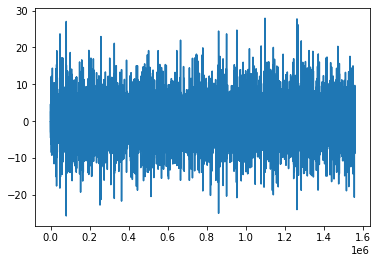

In [155]:
plt.plot(train_series['sensor_12_mean5'])

In [156]:
np.std(train_series['sensor_12_mean5'])

0.9999999999999999

In [152]:
model = MyModel(78, 16, num_layers=5)
train(train_series, train_labels, 1e-5, 200, 1)

1e-05
1e-05 1 - 0: 0.7063279305133806; test roc=0.5649794713882474 test loss=0.6867441534996033
saving model: 0.5649794713882474, gru_model_1e-05_seed_1.pickle
1e-05 1 - 1: 0.6927425924488664; test roc=0.6007225838057246 test loss=0.6770952939987183
saving model: 0.6007225838057246, gru_model_1e-05_seed_1.pickle
1e-05 1 - 2: 0.6769813900713982; test roc=0.660066018149159 test loss=0.6568613052368164
saving model: 0.660066018149159, gru_model_1e-05_seed_1.pickle
1e-05 1 - 3: 0.6587008770933865; test roc=0.7399882193762102 test loss=0.6058388948440552
saving model: 0.7399882193762102, gru_model_1e-05_seed_1.pickle
1e-05 1 - 4: 0.6145249808762302; test roc=0.7931281638556466 test loss=0.5600147843360901
saving model: 0.7931281638556466, gru_model_1e-05_seed_1.pickle
1e-05 1 - 5: 0.5726565742315003; test roc=0.8159120069050784 test loss=0.5313796401023865
saving model: 0.8159120069050784, gru_model_1e-05_seed_1.pickle
1e-05 1 - 6: 0.5346241692970016; test roc=0.8457525602444772 test loss=0

1e-05 1 - 75: 0.30174683117831796; test roc=0.919037371404577 test loss=0.4124287962913513
1e-05 1 - 76: 0.30249744537423073; test roc=0.9227272727272727 test loss=0.3929865062236786
1e-05 1 - 77: 0.2975753791975849; test roc=0.9150972776261458 test loss=0.4288513660430908
1e-05 1 - 78: 0.29893725267661103; test roc=0.9196578953507359 test loss=0.420448362827301
1e-05 1 - 79: 0.2969260968520323; test roc=0.9160059019758787 test loss=0.42532262206077576
1e-05 1 - 80: 0.2986672271921056; test roc=0.9206440851937389 test loss=0.39961639046669006
1e-05 1 - 81: 0.2923351969842589; test roc=0.9214045769473022 test loss=0.451713889837265
1e-05 1 - 82: 0.2919773553721098; test roc=0.9246821564373527 test loss=0.3896232843399048
saving model: 0.9246821564373527, gru_model_1e-05_seed_1.pickle
1e-05 1 - 83: 0.29369095769412124; test roc=0.9212896867053911 test loss=0.4227525591850281
1e-05 1 - 84: 0.2933608015306839; test roc=0.9190706137588355 test loss=0.42068299651145935
1e-05 1 - 85: 0.292718

KeyboardInterrupt: 

In [173]:
model = MyModel(78, 16, num_layers=5)
train(train_series, train_labels, 1e-5, 300, 3)

1e-05
1e-05 3 - 0: 0.7065998828261347; test roc=0.5248168843917542 test loss=0.69234299659729
saving model: 0.5248168843917542, gru_model_1e-05_seed_3.pickle
1e-05 3 - 1: 0.6949207416255263; test roc=0.5505134788189987 test loss=0.6943340301513672
saving model: 0.5505134788189987, gru_model_1e-05_seed_3.pickle
1e-05 3 - 2: 0.6795070675395479; test roc=0.5776760768492248 test loss=0.689204216003418
saving model: 0.5776760768492248, gru_model_1e-05_seed_3.pickle
1e-05 3 - 3: 0.6464343423113891; test roc=0.6905545786992588 test loss=0.6508488655090332
saving model: 0.6905545786992588, gru_model_1e-05_seed_3.pickle
1e-05 3 - 4: 0.6067293874984804; test roc=0.7319743044843098 test loss=0.6128301620483398
saving model: 0.7319743044843098, gru_model_1e-05_seed_3.pickle
1e-05 3 - 5: 0.5741059825457716; test roc=0.7687813507944898 test loss=0.5816972851753235
saving model: 0.7687813507944898, gru_model_1e-05_seed_3.pickle
1e-05 3 - 6: 0.542762958527514; test roc=0.7879737003915817 test loss=0.5

1e-05 3 - 64: 0.37754871854066563; test roc=0.9038424612463729 test loss=0.4561147391796112
1e-05 3 - 65: 0.3773404338328651; test roc=0.9092469336900356 test loss=0.4183522164821625
saving model: 0.9092469336900356, gru_model_1e-05_seed_3.pickle
1e-05 3 - 66: 0.37683843590884586; test roc=0.9129453835449455 test loss=0.45490744709968567
saving model: 0.9129453835449455, gru_model_1e-05_seed_3.pickle
1e-05 3 - 67: 0.3747365580247614; test roc=0.9078186858825688 test loss=0.45116323232650757
1e-05 3 - 68: 0.36979951864264543; test roc=0.9080624804478917 test loss=0.42793694138526917
1e-05 3 - 69: 0.3702724745496787; test roc=0.9111417352563619 test loss=0.43332961201667786
1e-05 3 - 70: 0.37065885948490673; test roc=0.9141379273147 test loss=0.4254223108291626
saving model: 0.9141379273147, gru_model_1e-05_seed_3.pickle
1e-05 3 - 71: 0.36745702837773514; test roc=0.9133067604448711 test loss=0.39731982350349426
1e-05 3 - 72: 0.3690152283257245; test roc=0.9092323707403372 test loss=0.41

1e-05 3 - 142: 0.32486237657601486; test roc=0.9303702225434463 test loss=0.405252605676651
1e-05 3 - 143: 0.3224790559088255; test roc=0.9286237473166417 test loss=0.3898920714855194
1e-05 3 - 144: 0.32109488129123437; test roc=0.9290854467589347 test loss=0.38107919692993164
1e-05 3 - 145: 0.3282348521757692; test roc=0.9311091573985179 test loss=0.3868361711502075
1e-05 3 - 146: 0.3241800082579186; test roc=0.9318437773055308 test loss=0.3635427951812744
1e-05 3 - 147: 0.321078736130536; test roc=0.9329643153795536 test loss=0.3912576138973236
1e-05 3 - 148: 0.3204752682480462; test roc=0.9327094637598299 test loss=0.35645315051078796
1e-05 3 - 149: 0.3224919175008266; test roc=0.9301010776582777 test loss=0.36663809418678284
1e-05 3 - 150: 0.31755166643253807; test roc=0.9330077345443952 test loss=0.36431828141212463
1e-05 3 - 151: 0.3251122708134757; test roc=0.9337256340276805 test loss=0.3954850435256958
1e-05 3 - 152: 0.31968434229608533; test roc=0.9298297752990797 test loss=0

1e-05 3 - 225: 0.2987052691750058; test roc=0.9392671060722106 test loss=0.36386439204216003
1e-05 3 - 226: 0.30063433164348907; test roc=0.9373264581827596 test loss=0.35568737983703613
1e-05 3 - 227: 0.29797517212219643; test roc=0.9390834510954574 test loss=0.3651571273803711
1e-05 3 - 228: 0.29436333161831474; test roc=0.9374143752494579 test loss=0.35760223865509033
1e-05 3 - 229: 0.2935274787345907; test roc=0.9395785913852063 test loss=0.3484398424625397
1e-05 3 - 230: 0.2952261672611184; test roc=0.9420524050441743 test loss=0.3395170569419861
saving model: 0.9420524050441743, gru_model_1e-05_seed_3.pickle
1e-05 3 - 231: 0.29001789631213365; test roc=0.9386187851263741 test loss=0.3359023332595825
1e-05 3 - 232: 0.29414260902332573; test roc=0.9361010129340568 test loss=0.3509274423122406
1e-05 3 - 233: 0.29557479535152736; test roc=0.9404348388906268 test loss=0.3405758738517761
1e-05 3 - 234: 0.2967318944123993; test roc=0.9370872482497492 test loss=0.3520858883857727
1e-05 3

In [175]:
model = MyModel(78, 16, num_layers=5)
train(train_series, train_labels, 1e-5, 300, 3, batch_size=1024)

1e-05
1e-05 3 - 0: 0.7005025986303173; test roc=0.49286604243751414 test loss=0.6935303211212158
saving model: 0.49286604243751414, gru_model_1e-05_seed_3.pickle
1e-05 3 - 1: 0.6943018942420033; test roc=0.5608315983646346 test loss=0.6909206509590149
saving model: 0.5608315983646346, gru_model_1e-05_seed_3.pickle
1e-05 3 - 2: 0.6854371734359674; test roc=0.5767089891155435 test loss=0.6857242584228516
saving model: 0.5767089891155435, gru_model_1e-05_seed_3.pickle
1e-05 3 - 3: 0.6740130870544527; test roc=0.6010385540609056 test loss=0.6839624047279358
saving model: 0.6010385540609056, gru_model_1e-05_seed_3.pickle
1e-05 3 - 4: 0.6558786508261983; test roc=0.6371953916354731 test loss=0.6749252080917358
saving model: 0.6371953916354731, gru_model_1e-05_seed_3.pickle
1e-05 3 - 5: 0.6309679455835916; test roc=0.700968166470696 test loss=0.637568473815918
saving model: 0.700968166470696, gru_model_1e-05_seed_3.pickle
1e-05 3 - 6: 0.60810154751315; test roc=0.7320627609195154 test loss=0.

1e-05 3 - 62: 0.3815426786730364; test roc=0.9014093699097097 test loss=0.4157777726650238
1e-05 3 - 63: 0.37806785385655034; test roc=0.8985846970367095 test loss=0.42936214804649353
1e-05 3 - 64: 0.38337366802724004; test roc=0.9047275649669367 test loss=0.41552963852882385
1e-05 3 - 65: 0.3800819314781636; test roc=0.904321420480901 test loss=0.3994554579257965
1e-05 3 - 66: 0.3768239979478501; test roc=0.9092744414839106 test loss=0.39384010434150696
saving model: 0.9092744414839106, gru_model_1e-05_seed_3.pickle
1e-05 3 - 67: 0.37582745123927064; test roc=0.9056935739636034 test loss=0.40453293919563293
1e-05 3 - 68: 0.37703836872478785; test roc=0.9075932298464957 test loss=0.39989346265792847
1e-05 3 - 69: 0.37073386559652965; test roc=0.9072367072631364 test loss=0.3972482681274414
1e-05 3 - 70: 0.37050167606693807; test roc=0.9078332488322672 test loss=0.393206387758255
1e-05 3 - 71: 0.37383591145087264; test roc=0.9077232176567674 test loss=0.41098958253860474
1e-05 3 - 72: 0

1e-05 3 - 145: 0.33507395545067176; test roc=0.9291280568710153 test loss=0.350299596786499
1e-05 3 - 146: 0.3286703049551905; test roc=0.929294721739787 test loss=0.34834128618240356
saving model: 0.929294721739787, gru_model_1e-05_seed_3.pickle
1e-05 3 - 147: 0.329064855321593; test roc=0.9263702656929267 test loss=0.3654003441333771
1e-05 3 - 148: 0.33033084045217975; test roc=0.9283907401214658 test loss=0.3518419861793518
1e-05 3 - 149: 0.33443113489644166; test roc=0.926510501504838 test loss=0.3635751008987427
1e-05 3 - 150: 0.334520735160719; test roc=0.9325638342628451 test loss=0.3446126878261566
saving model: 0.9325638342628451, gru_model_1e-05_seed_3.pickle
1e-05 3 - 151: 0.3305637483557004; test roc=0.9302245930464612 test loss=0.34258168935775757
1e-05 3 - 152: 0.32713835786837675; test roc=0.9253287451052308 test loss=0.365373820066452
1e-05 3 - 153: 0.33046397253950455; test roc=0.9266639518451797 test loss=0.3579157292842865
1e-05 3 - 154: 0.3260809028185577; test roc=

1e-05 3 - 228: 0.3133189146919969; test roc=0.9342596088499585 test loss=0.33701062202453613
1e-05 3 - 229: 0.3110673397374305; test roc=0.93373588202932 test loss=0.33530595898628235
1e-05 3 - 230: 0.31385447489807067; test roc=0.9349634847520523 test loss=0.3389105796813965
1e-05 3 - 231: 0.3165782162314786; test roc=0.9386150095468224 test loss=0.3209559917449951
saving model: 0.9386150095468224, gru_model_1e-05_seed_3.pickle
1e-05 3 - 232: 0.31251686370899995; test roc=0.9352800940658678 test loss=0.3342377245426178
1e-05 3 - 233: 0.31614816437549587; test roc=0.9363804058208649 test loss=0.33135730028152466
1e-05 3 - 234: 0.3149123876963809; test roc=0.9350848426662065 test loss=0.33436325192451477
1e-05 3 - 235: 0.3156611692564887; test roc=0.9337728287720737 test loss=0.3422994613647461
1e-05 3 - 236: 0.311466849582615; test roc=0.9372924779667964 test loss=0.3339653015136719
1e-05 3 - 237: 0.3141313524485004; test roc=0.9318718244679132 test loss=0.34497442841529846
1e-05 3 - 2

In [176]:
sum_size = 0
for para in model.named_parameters():
    sum_size += np.prod(para[1].shape)
    print(f"{para[0]} || {np.prod(para[1].shape)}")
print(f"total = {sum_size}")

fc_pre.weight || 1248
fc_pre.bias || 16
bn_pre.weight || 60
bn_pre.bias || 60
gru.weight_ih_l0 || 768
gru.weight_hh_l0 || 768
gru.bias_ih_l0 || 48
gru.bias_hh_l0 || 48
gru.weight_ih_l1 || 768
gru.weight_hh_l1 || 768
gru.bias_ih_l1 || 48
gru.bias_hh_l1 || 48
gru.weight_ih_l2 || 768
gru.weight_hh_l2 || 768
gru.bias_ih_l2 || 48
gru.bias_hh_l2 || 48
gru.weight_ih_l3 || 768
gru.weight_hh_l3 || 768
gru.bias_ih_l3 || 48
gru.bias_hh_l3 || 48
gru.weight_ih_l4 || 768
gru.weight_hh_l4 || 768
gru.bias_ih_l4 || 48
gru.bias_hh_l4 || 48
bn_post.weight || 16
bn_post.bias || 16
fc_post.weight || 16
fc_post.bias || 1
total = 9593


In [178]:
model = MyModel(78, 32, num_layers=5)

In [179]:
sum_size = 0
for para in model.named_parameters():
    sum_size += np.prod(para[1].shape)
    print(f"{para[0]} || {np.prod(para[1].shape)}")
print(f"total = {sum_size}")

fc_pre.weight || 2496
fc_pre.bias || 32
bn_pre.weight || 60
bn_pre.bias || 60
gru.weight_ih_l0 || 3072
gru.weight_hh_l0 || 3072
gru.bias_ih_l0 || 96
gru.bias_hh_l0 || 96
gru.weight_ih_l1 || 3072
gru.weight_hh_l1 || 3072
gru.bias_ih_l1 || 96
gru.bias_hh_l1 || 96
gru.weight_ih_l2 || 3072
gru.weight_hh_l2 || 3072
gru.bias_ih_l2 || 96
gru.bias_hh_l2 || 96
gru.weight_ih_l3 || 3072
gru.weight_hh_l3 || 3072
gru.bias_ih_l3 || 96
gru.bias_hh_l3 || 96
gru.weight_ih_l4 || 3072
gru.weight_hh_l4 || 3072
gru.bias_ih_l4 || 96
gru.bias_hh_l4 || 96
bn_post.weight || 32
bn_post.bias || 32
fc_post.weight || 32
fc_post.bias || 1
total = 34425


In [182]:
sum_size = 0
for para in model.named_parameters():
    sum_size += np.prod(para[1].shape)
    print(f"{para[0]} || {np.prod(para[1].shape)}")
print(f"total = {sum_size}")

fc_pre.weight || 2496
fc_pre.bias || 32
bn_pre.weight || 60
bn_pre.bias || 60
gru.weight_ih_l0 || 3072
gru.weight_hh_l0 || 3072
gru.bias_ih_l0 || 96
gru.bias_hh_l0 || 96
bn_post.weight || 32
bn_post.bias || 32
fc_post.weight || 32
fc_post.bias || 1
total = 9081


In [185]:
model = MyModel(78, 32, num_layers=1)
train(train_series, train_labels, 1e-5, 300, 3, batch_size=256)

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1


1e-05
1e-05 3 - 0: 0.6909476880710479; test roc=0.5653326285584838 test loss=0.6860886812210083
saving model: 0.5653326285584838, gru_model_1e-05_seed_3.pickle
1e-05 3 - 1: 0.6683052112140829; test roc=0.6282736971553704 test loss=0.6748576164245605
saving model: 0.6282736971553704, gru_model_1e-05_seed_3.pickle
1e-05 3 - 2: 0.6082682799931916; test roc=0.7491019514352597 test loss=0.6125337481498718
saving model: 0.7491019514352597, gru_model_1e-05_seed_3.pickle
1e-05 3 - 3: 0.5530385229575656; test roc=0.7939795687209416 test loss=0.5517571568489075
saving model: 0.7939795687209416, gru_model_1e-05_seed_3.pickle
1e-05 3 - 4: 0.5152661475538695; test roc=0.816086126363254 test loss=0.5780678987503052
saving model: 0.816086126363254, gru_model_1e-05_seed_3.pickle
1e-05 3 - 5: 0.48788450420610546; test roc=0.8352250784781179 test loss=0.5187501311302185
saving model: 0.8352250784781179, gru_model_1e-05_seed_3.pickle
1e-05 3 - 6: 0.4754910464542004; test roc=0.8447594955825719 test loss=

1e-05 3 - 66: 0.27048396334408525; test roc=0.9434197042103106 test loss=0.3179943561553955
saving model: 0.9434197042103106, gru_model_1e-05_seed_3.pickle
1e-05 3 - 67: 0.2690796968531145; test roc=0.9393048618677252 test loss=0.3306125998497009
1e-05 3 - 68: 0.26800408185995134; test roc=0.9438733131249932 test loss=0.3231348991394043
saving model: 0.9438733131249932, gru_model_1e-05_seed_3.pickle
1e-05 3 - 69: 0.2662995541142917; test roc=0.9383712149814998 test loss=0.37342146039009094
1e-05 3 - 70: 0.26766540686309986; test roc=0.9423663175154527 test loss=0.3285824656486511
1e-05 3 - 71: 0.2650298117883561; test roc=0.9448377040161378 test loss=0.3194108307361603
saving model: 0.9448377040161378, gru_model_1e-05_seed_3.pickle
1e-05 3 - 72: 0.2635033379280512; test roc=0.9457605635322164 test loss=0.3104386031627655
saving model: 0.9457605635322164, gru_model_1e-05_seed_3.pickle
1e-05 3 - 73: 0.26344812780008364; test roc=0.9441683476985147 test loss=0.32464250922203064
1e-05 3 - 

1e-05 3 - 148: 0.2284267996422622; test roc=0.9504697899699032 test loss=0.3089277744293213
1e-05 3 - 149: 0.2319655111602858; test roc=0.9500960075943086 test loss=0.2996310591697693
1e-05 3 - 150: 0.23694856519995325; test roc=0.9497324732203536 test loss=0.2921128273010254
1e-05 3 - 151: 0.2307090964447178; test roc=0.954373739226114 test loss=0.28724196553230286
saving model: 0.954373739226114, gru_model_1e-05_seed_3.pickle
1e-05 3 - 152: 0.22999634690014759; test roc=0.9515986882557901 test loss=0.2978409230709076
1e-05 3 - 153: 0.22744815095148774; test roc=0.9535565959374764 test loss=0.2799316644668579
1e-05 3 - 154: 0.22772433479914175; test roc=0.9509568397320416 test loss=0.2889491617679596
1e-05 3 - 155: 0.23256142583110415; test roc=0.9479358367223654 test loss=0.3038884401321411
1e-05 3 - 156: 0.2288118738343231; test roc=0.9500404526380515 test loss=0.2957194447517395
1e-05 3 - 157: 0.22833778142590588; test roc=0.951701168272187 test loss=0.29535552859306335
1e-05 3 - 1

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [186]:
import glob

In [191]:
model_names = glob.glob('gru*1e-05*3*.pickle')

In [192]:
model_names

['gru_model_1e-05_seed_3.pickle']

In [195]:
train_dataloader = DataLoader(mydataset, shuffle=False, batch_size=len(mydataset))
X, y = next(iter(train_dataloader))

model = MyModel(78, 32, num_layers=1)
train_output = pd.DataFrame()
train_output['label'] = train_labels['state']
for model_name in model_names:
    tmp = torch.load(model_name)
    print(model_name, tmp['score'])
    if tmp['score'] > 0.95:        
        model.load_state_dict(tmp['model'])
        model.eval()
        with torch.no_grad():
            hidden = model.initHidden(len(X))
            pred = model(X, hidden).detach().numpy()
            train_output[model_name] = pred[:]

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1


gru_model_1e-05_seed_3.pickle 0.9554341377115673


In [196]:
train_output

label  gru_model_1e-05_seed_3.pickle
0          0                       0.000497
1          1                       0.899283
2          1                       0.997273
3          1                       0.846825
4          1                       0.995346
...      ...                            ...
25963      1                       0.999329
25964      0                       0.001625
25965      1                       0.957222
25966      1                       0.995362
25967      0                       0.144536

[25968 rows x 2 columns]

In [198]:
nn_train_output = pd.read_csv('nn_train_output.csv')
nn_train_output

label  nn_model_1e-05_isplit_2.pickle  nn_model_1e-05_isplit_0.pickle  \
0          0                        0.000428                        0.000670   
1          1                        0.822656                        0.948457   
2          1                        0.993019                        0.998480   
3          1                        0.783070                        0.870413   
4          1                        0.963354                        0.990503   
...      ...                             ...                             ...   
25963      1                        0.992234                        0.988758   
25964      0                        0.007409                        0.000589   
25965      1                        0.837370                        0.553210   
25966      1                        0.986278                        0.972275   
25967      0                        0.167205                        0.117789   

       nn_model_1e-05_isplit_4.pickle  nn_model_1e-05_isplit_3.pickle  \
0                            0.001373                        0.004204   
1                            0.830469                        0.989444   
2                            0.991656                        0.982240   
3                            0.520563                        0.864861   
4                            0.659269                        0.984968   
...                               ...                             ...   
25963                        0.989263                        0.988569   
25964                        0.003515                        0.022195   
25965                        0.819429                        0.954351   
25966                        0.977593                        0.975883   
25967                        0.026188                        0.095891   

       nn_model_1e-05_isplit_1.pickle  
0                            0.000526  
1                            0.875767  
2                            0.985368  
3                            0.651066  
4                            0.913403  
...                               ...  
25963                        0.967122  
25964                        0.002654  
25965                        0.712913  
25966                        0.985457  
25967                        0.077494  

[25968 rows x 6 columns]

In [203]:
train_output = pd.concat([train_output, nn_train_output.drop(columns=['label'])], axis=1)

In [204]:
train_output.corr()

label  gru_model_1e-05_seed_3.pickle  \
label                           1.000000                       0.889679   
gru_model_1e-05_seed_3.pickle   0.889679                       1.000000   
nn_model_1e-05_isplit_2.pickle  0.916477                       0.926461   
nn_model_1e-05_isplit_0.pickle  0.931021                       0.929551   
nn_model_1e-05_isplit_4.pickle  0.913166                       0.924713   
nn_model_1e-05_isplit_3.pickle  0.919100                       0.928279   
nn_model_1e-05_isplit_1.pickle  0.917209                       0.923754   

                                nn_model_1e-05_isplit_2.pickle  \
label                                                 0.916477   
gru_model_1e-05_seed_3.pickle                         0.926461   
nn_model_1e-05_isplit_2.pickle                        1.000000   
nn_model_1e-05_isplit_0.pickle                        0.971021   
nn_model_1e-05_isplit_4.pickle                        0.968347   
nn_model_1e-05_isplit_3.pickle                        0.971394   
nn_model_1e-05_isplit_1.pickle                        0.965108   

                                nn_model_1e-05_isplit_0.pickle  \
label                                                 0.931021   
gru_model_1e-05_seed_3.pickle                         0.929551   
nn_model_1e-05_isplit_2.pickle                        0.971021   
nn_model_1e-05_isplit_0.pickle                        1.000000   
nn_model_1e-05_isplit_4.pickle                        0.968625   
nn_model_1e-05_isplit_3.pickle                        0.972608   
nn_model_1e-05_isplit_1.pickle                        0.968070   

                                nn_model_1e-05_isplit_4.pickle  \
label                                                 0.913166   
gru_model_1e-05_seed_3.pickle                         0.924713   
nn_model_1e-05_isplit_2.pickle                        0.968347   
nn_model_1e-05_isplit_0.pickle                        0.968625   
nn_model_1e-05_isplit_4.pickle                        1.000000   
nn_model_1e-05_isplit_3.pickle                        0.965357   
nn_model_1e-05_isplit_1.pickle                        0.965180   

                                nn_model_1e-05_isplit_3.pickle  \
label                                                 0.919100   
gru_model_1e-05_seed_3.pickle                         0.928279   
nn_model_1e-05_isplit_2.pickle                        0.971394   
nn_model_1e-05_isplit_0.pickle                        0.972608   
nn_model_1e-05_isplit_4.pickle                        0.965357   
nn_model_1e-05_isplit_3.pickle                        1.000000   
nn_model_1e-05_isplit_1.pickle                        0.965258   

                                nn_model_1e-05_isplit_1.pickle  
label                                                 0.917209  
gru_model_1e-05_seed_3.pickle                         0.923754  
nn_model_1e-05_isplit_2.pickle                        0.965108  
nn_model_1e-05_isplit_0.pickle                        0.968070  
nn_model_1e-05_isplit_4.pickle                        0.965180  
nn_model_1e-05_isplit_3.pickle                        0.965258  
nn_model_1e-05_isplit_1.pickle                        1.000000

In [205]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [213]:
params = {'C': [1e-3,1e-2,1e-1,1.0,1e+1]}
gcv = GridSearchCV(LogisticRegression(), params)

In [214]:
X, y = nn_train_output.drop(columns=['label']), nn_train_output['label']
gcv.fit(X, y)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0]})

In [215]:
gcv.best_params_, gcv.best_score_

({'C': 0.1}, 0.9584488790447672)

In [216]:
roc_auc_score(y, gcv.predict_proba(X)[:,1])

0.9927715521335333

In [217]:
X, y = train_output.drop(columns=['label']), train_output['label']
gcv.fit(X, y)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0]})

In [218]:
gcv.best_params_, gcv.best_score_

({'C': 0.1}, 0.9597196279076252)

In [219]:
roc_auc_score(y, gcv.predict_proba(X)[:,1])

0.9932455075814246